# Evaluation metrics for classification

## About 
This notebook is extension of the telco customer churn notebook and will cover all the evaluation metrics generally used to verify the effectiveness of model. We will use the same dataset and model to generate prediction and check the different kinds of evaluation metrics and how to interpret that.

## Contents
- Overview from telco customer churn notebook
- Accuracy and dummy model


### Overview from telco customer churn notebook

First we will import all the necessary libraries and perform some basic data preparation as we did in the telco-customer churn notebook

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('../datasets/Telco-Customer-Churn.CSV')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

Then we will split the data into train, test and validation datasets and store the targer values for the respective datasets separately.

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

Then will will split the numrical features with categorical features, perform one hot encoding for the categorical features and then generate predictions for the model

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\ugosw\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

### Accuracy and dummy model

We will use the accuracy_score class from sklearn library to calcualte our accuracy score of our model

In [8]:
from sklearn.metrics import accuracy_score

In [9]:
accuracy_score(y_val, y_pred >=0.5)

0.8034066713981547

We will check the accuracy for our model with multiple thresholds and pick the one in which it performs the best.

In [10]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f --> %.3f' % (t, score))
    scores.append(score)

0.00 --> 0.274
0.05 --> 0.510
0.10 --> 0.591
0.15 --> 0.666
0.20 --> 0.710
0.25 --> 0.736
0.30 --> 0.760
0.35 --> 0.773
0.40 --> 0.785
0.45 --> 0.792
0.50 --> 0.803
0.55 --> 0.801
0.60 --> 0.795
0.65 --> 0.786
0.70 --> 0.766
0.75 --> 0.744
0.80 --> 0.733
0.85 --> 0.726
0.90 --> 0.726
0.95 --> 0.726
1.00 --> 0.726


we can also plot a graph to see how the accuracy score changes with the different threshold values

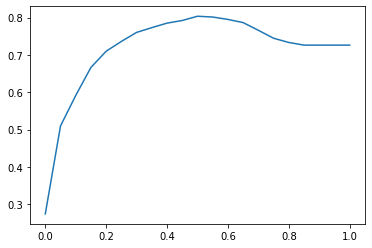

In [11]:
plt.plot(thresholds, scores)

In [12]:
from collections import Counter

In [13]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [14]:
1 - y_val.mean()

0.7260468417317246

### Confusion table

In [15]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [16]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [17]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [18]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[923, 100],
       [177, 209]])

In [19]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.13, 0.15]])

## Precision and recall

In [20]:
p = tp / (tp + fp)
p

0.6763754045307443

In [21]:
r = tp / (tp + fn)
r

0.5414507772020726

## ROC Curves

In [22]:
tpr = tp / (tp + fn)
tpr

0.5414507772020726

In [23]:
fpr = fp / (fp + tn)
fpr

0.09775171065493646

In [24]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [25]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

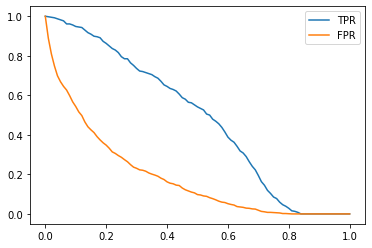

In [26]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

## Random model

In [27]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [28]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [29]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [30]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

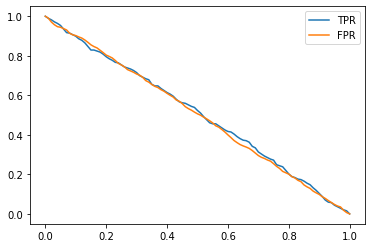

In [31]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

## Ideal meodel

In [32]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [33]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [34]:
1 - y_val.mean()

0.7260468417317246

In [35]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [36]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


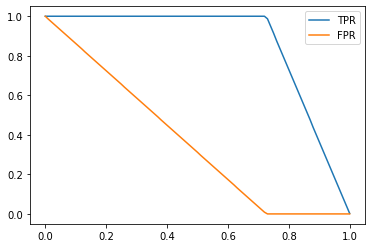

In [37]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

## Putting everything together

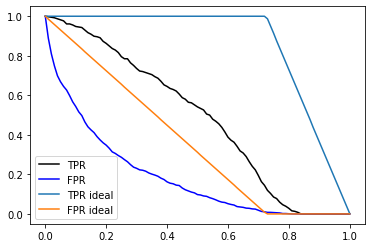

In [38]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

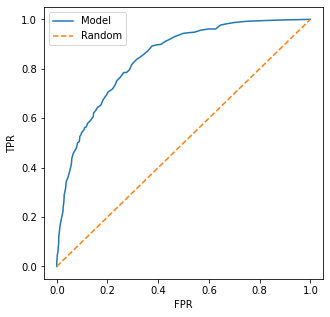

In [39]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [40]:
from sklearn.metrics import roc_curve

In [41]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

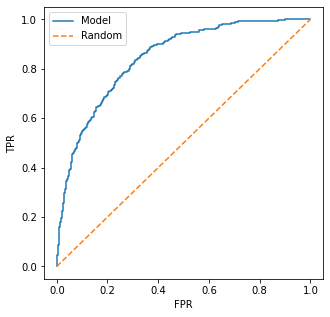

In [42]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## ROC AUC

In [43]:
from sklearn.metrics import auc

In [44]:
auc(fpr, tpr)

0.8439847243958893

In [45]:
auc(df_scores.fpr, df_scores.tpr)

0.8434972320564833

In [46]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [47]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8439847243958893

In [48]:
from sklearn.metrics import roc_auc_score

In [49]:
roc_auc_score(y_val, y_pred)

0.8439847243958893

In [50]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [51]:
import random

In [52]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84323

In [53]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84672

## Cross vaidation

In [54]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [55]:
dv, model = train(df_train, y_train, C=0.001)

In [56]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [57]:
y_pred = predict(df_val, dv, model)

In [58]:
from sklearn.model_selection import KFold

In [59]:
! pip install tqdm

     -------------------------------------- 78.5/78.5 KB 434.6 kB/s eta 0:00:00


You should consider upgrading via the 'C:\Users\ugosw\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [60]:
from tqdm.auto import tqdm

c:\Users\ugosw\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:04<00:24,  4.11s/it]

C=0.001 0.825 +- 0.009


 29%|██▊       | 2/7 [00:07<00:18,  3.66s/it]

C=0.01 0.840 +- 0.009


 43%|████▎     | 3/7 [00:11<00:14,  3.66s/it]

C=0.1 0.841 +- 0.008


 57%|█████▋    | 4/7 [00:14<00:10,  3.46s/it]

C=0.5 0.840 +- 0.007


 71%|███████▏  | 5/7 [00:17<00:06,  3.38s/it]

C=1 0.840 +- 0.008


 86%|████████▌ | 6/7 [00:21<00:03,  3.45s/it]

C=5 0.841 +- 0.008


100%|██████████| 7/7 [00:24<00:00,  3.49s/it]

C=10 0.841 +- 0.008


In [62]:
scores

[0.841935458548877,
 0.8457882234141173,
 0.8324703993578166,
 0.831959055445418,
 0.8525501239371216]

In [63]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259